# Rossman Store Sales Prediction

- Use training data to build a model to run on test data - sales is outcome
- Minimize Root Mean Square Percentage Error (RMSPE).

### Variables
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import timeit


%matplotlib inline

In [2]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [3]:
#hide warnings
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## notes

predicting sales - quantity

check number of samples to determine appropriate algorithm


In [4]:
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')

In [5]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
store_df['Store'].nunique()

1115

There are 1,115 stores

In [7]:
df = pd.read_csv('train.csv')

In [8]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
df.shape

(1017209, 9)

- over 1 million rows
- 2 outcomes (sales and customers)
- 6 vars in main table
- 9 vars in store table

In [10]:
#merge tables
df = pd.merge(df,store_df,left_on='Store',right_on='Store')

In [11]:
df.shape

(1017209, 18)

In [12]:
#create ID variable
df['unique'] = df['Store'].astype(str) + df['Date'].astype(str)

In [13]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,unique
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,12015-07-31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,12015-07-30
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,12015-07-29
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,12015-07-28
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,12015-07-27


In [14]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [15]:
df[df.Open == 0].Sales.describe()

count    172817.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Sales, dtype: float64

In [16]:
df[df.Open == 0].Customers.describe()

count    172817.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Customers, dtype: float64

Sales and customers are always zero when store is closed.  Drop these because they're not useful. Remember to predict 0 customers and 0 sales when Open = 0

In [17]:
df = df[df.Open == 1]

In [18]:
df.shape

(844392, 19)

In [19]:
df.Store.nunique()

1115

Seems some of the stores were never open

In [20]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,842206.000000,575773.000000,575773.000000,844392.000000,421085.000000,421085.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5457.979627,7.224879,2008.697747,0.498684,23.253426,2011.754019
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7809.437311,3.210144,5.978048,0.499999,14.100569,1.660962
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,8.000000,2010.000000,0.000000,22.000000,2012.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [21]:
def hist(title,data,kde_bool):
    ax = plt.axes()
    ax.set_title(title)
    sns.distplot(data,ax=ax,kde=kde_bool)

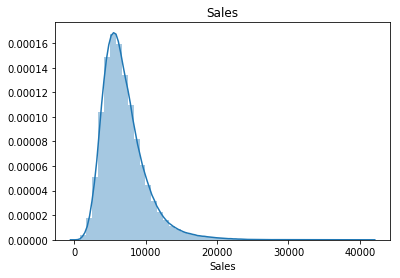

In [22]:
hist('Sales',df.Sales,True)

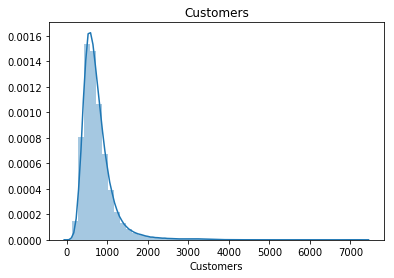

In [23]:
hist('Customers',df.Customers,True)

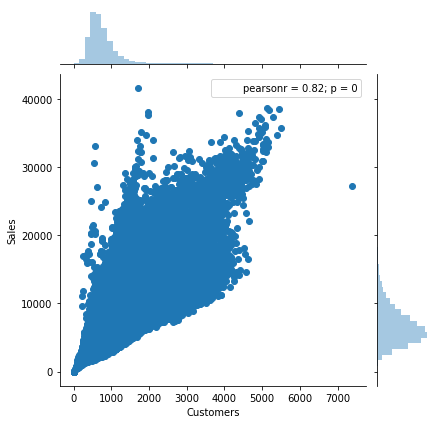

In [24]:
sns.jointplot(x=df["Customers"], y=df["Sales"], kind='scatter')

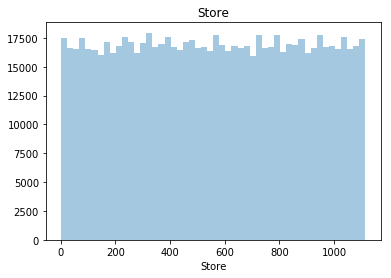

In [25]:
hist('Store',df.Store,False)

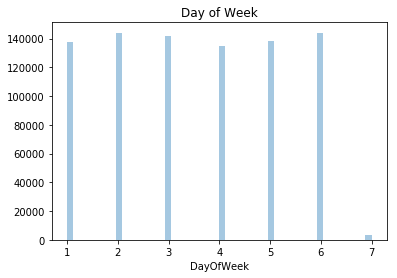

In [26]:
hist('Day of Week',df.DayOfWeek,False)

makes sense that a lot of stores would be closed on Sunday

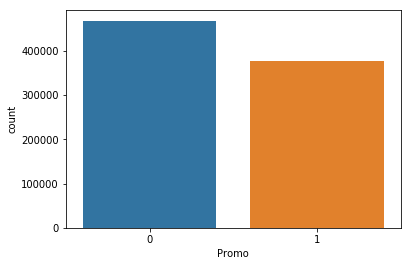

In [27]:
sns.countplot(df.Promo)

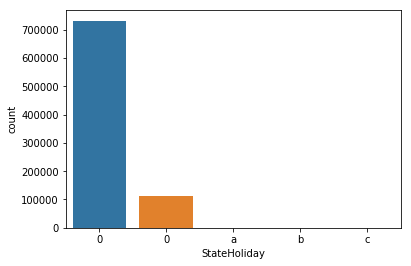

In [28]:
sns.countplot(df.StateHoliday)

In [29]:
#something is wrong here

In [30]:
print df[df.StateHoliday==0].shape[0]
print df[df.StateHoliday=='0'].shape[0]
print df[df.StateHoliday=='a'].shape[0]
print df[df.StateHoliday=='b'].shape[0]
print df[df.StateHoliday=='c'].shape[0]

#string zero and int zero should be the same - will omit both for dummy vars

112140
731342
694
145
71


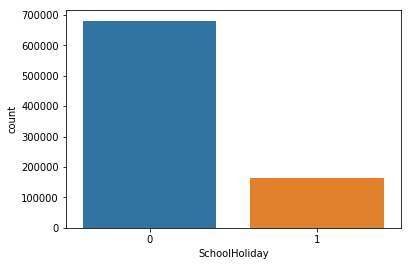

In [31]:
sns.countplot(df.SchoolHoliday)

In [32]:
# what is the overlap between school and state holidays?

print df[df.SchoolHoliday == 1][df.StateHoliday == 0].shape[0]
print df[df.SchoolHoliday == 0][df.StateHoliday != 0].shape[0]
print df[df.SchoolHoliday == 0][df.StateHoliday == 'a'].shape[0]
print df[df.SchoolHoliday == 1][df.StateHoliday == 'a'].shape[0]
print df[df.SchoolHoliday == 0][df.StateHoliday == 'b'].shape[0]
print df[df.SchoolHoliday == 0][df.StateHoliday == 'c'].shape[0]

29284
598079
590
104
6
0


There are some school holidays that are not state holidays.
There are also state holidays that are not school holidays.

Therefore it is likely better to start by using separate variables and then control for covariance and errors later.

In [33]:
#create new state holiday variables

In [34]:
def holiday(name,x):
    if name == x:
        return 1
    else:
        return 0

df['holiday_a'] = df.StateHoliday.apply(lambda x: holiday('a',x))
df['holiday_b'] = df.StateHoliday.apply(lambda x: holiday('b',x))
df['holiday_c'] = df.StateHoliday.apply(lambda x: holiday('c',x))

In [35]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'unique', u'holiday_a',
       u'holiday_b', u'holiday_c'],
      dtype='object')

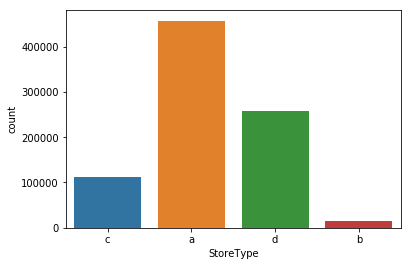

In [36]:
sns.countplot(df.StoreType)

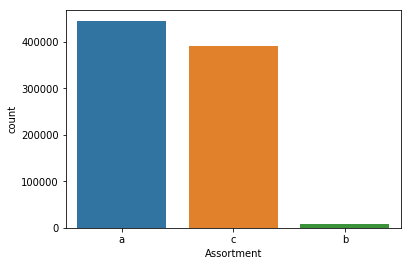

In [37]:
sns.countplot(df.Assortment)

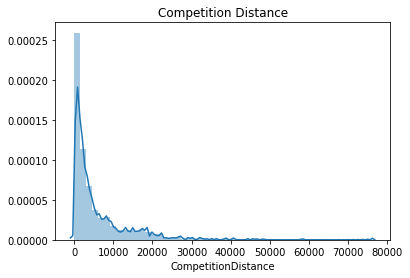

In [38]:
hist('Competition Distance',df[df.CompetitionDistance >= 0].CompetitionDistance,True)

## Competition time and Promo time

In [39]:
#should combine year + month to new variable

Time delta should be found between comp. start or promo start and date of observation.

### Competition Time

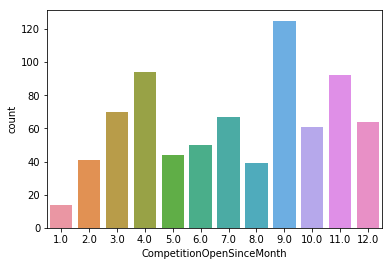

In [40]:
sns.countplot(store_df.CompetitionOpenSinceMonth)

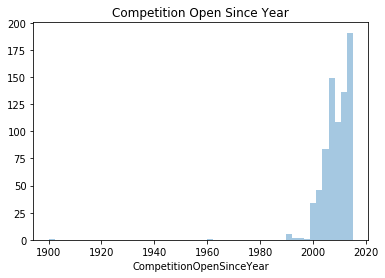

In [41]:
hist('Competition Open Since Year',store_df[store_df.CompetitionOpenSinceYear >0].CompetitionOpenSinceYear,False)

In [42]:
store_df.CompetitionOpenSinceYear.describe()

count     761.000000
mean     2008.668857
std         6.195983
min      1900.000000
25%      2006.000000
50%      2010.000000
75%      2013.000000
max      2015.000000
Name: CompetitionOpenSinceYear, dtype: float64

According to wikipedia, Rossman stores first opened in 1972.  Dates before then are irrelevant and should be omitted.

In [43]:
store_df.CompetitionOpenSinceYear.sort_values().head()

814    1900.0
145    1961.0
991    1990.0
706    1990.0
328    1990.0
Name: CompetitionOpenSinceYear, dtype: float64

In [44]:
df = df[df.CompetitionOpenSinceYear != 1900]
df = df[df.CompetitionOpenSinceYear != 1961]

### Promo Time

In [45]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'unique', u'holiday_a',
       u'holiday_b', u'holiday_c'],
      dtype='object')

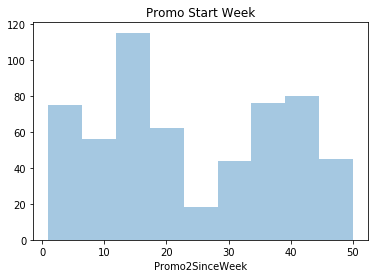

In [46]:
hist('Promo Start Week',store_df[store_df.Promo2SinceWeek >=0].Promo2SinceWeek, False)

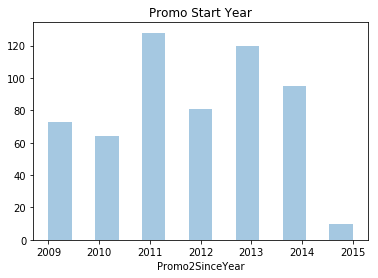

In [47]:
hist('Promo Start Year',store_df[store_df.Promo2SinceYear >=0].Promo2SinceYear, False)

In [48]:
store_df.Promo2SinceWeek.describe()

count    571.000000
mean      23.595447
std       14.141984
min        1.000000
25%       13.000000
50%       22.000000
75%       37.000000
max       50.000000
Name: Promo2SinceWeek, dtype: float64

### Creating new variables

In [50]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'unique', u'holiday_a',
       u'holiday_b', u'holiday_c'],
      dtype='object')

In [60]:
#create functions for promo time and competition time

def promo_time(dataframe,ID):
    #gives time promo has been active in weeks
    u = dataframe[dataframe.unique == ID]
    if u.Promo2.item() == 1:
        now = u.Date.item()
        week = u.Promo2SinceWeek.item()
        year = u.Promo2SinceYear.item()
        now = datetime.strptime(now, '%Y-%m-%d').isocalendar()
        t = (now[0] - year)*52 + (now[1] - week)
        if t > 0:
            return t
        else:
            return 0
    else:
        return 0

def competition_time(dataframe,ID):
    #gives time of competition in months
    u = dataframe[dataframe.unique == ID]
    month = u.CompetitionOpenSinceMonth.item()
    year = u.CompetitionOpenSinceYear.item()
    now = datetime.strptime(u.Date.item(), '%Y-%m-%d')
    t = (now.year - year)*12 + (now.month - month)
    if t > 0:
        return t
    else:
        return 0
    
def year_var(dataframe, ID):
    #gives the year of the observation
    u = dataframe[dataframe.unique == ID]
    return datetime.strptime(u.Date.item(), '%Y-%m-%d').year

def month_var(dataframe, ID):
    #gives the month of the observation
    u = dataframe[dataframe.unique == ID]
    return datetime.strptime(u.Date.item(), '%Y-%m-%d').month

In [55]:
year_var(df,'22015-07-31')

2015

In [52]:
start_time = timeit.default_timer()
print promo_time(df,'22015-07-31')
print (timeit.default_timer() - start_time)

278.0
0.0677280426025


In [56]:
start_time = timeit.default_timer()
competition_time(df,'12015-07-31')
print (timeit.default_timer() - start_time)

0.0631799697876


In [57]:
df.shape

(842991, 22)

Both functions take about 0.06 seconds.  The dataframe is 842991 rows.  The CPU load is already apparent, and we're not even to the actual ML yet.

There are now 2 options:
- Run an Amazon EC2 instance (currently getting an "insufficient capacity" error)
- Take a random sub-set (2% still leaves 16,860 rows.  As long as there are at least some from each store this is ok for now)

In [93]:
#resample until number of stores is 1113
df_sample = df.sample(frac=0.03)
df_sample.Store.nunique()

1113

In [94]:
df_sample['year'] = df_sample.unique.apply(lambda x: year_var(df_sample, x))
df_sample['month'] = df_sample.unique.apply(lambda x: month_var(df_sample, x))

In [95]:
df_sample['promo_time'] = df_sample.unique.apply(lambda x: promo_time(df_sample,x))

In [96]:
df_sample['competition_time'] = df_sample.unique.apply(lambda x: competition_time(df_sample,x))

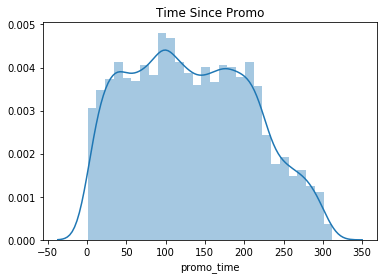

In [97]:
hist('Time Since Promo', df_sample[df_sample.promo_time !=0]['promo_time'], True)

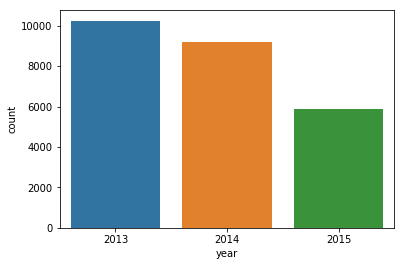

In [98]:
sns.countplot(df_sample['year'])

not much use for year with such a limited range

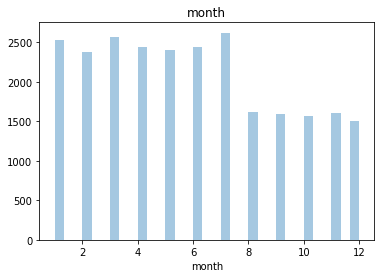

In [99]:
hist('month', df_sample['month'], False)

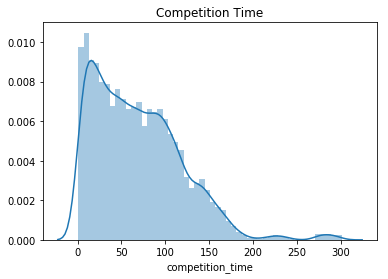

In [100]:
hist('Competition Time', df_sample[df_sample.competition_time !=0]['competition_time'], True)

## Independent Variables Continued

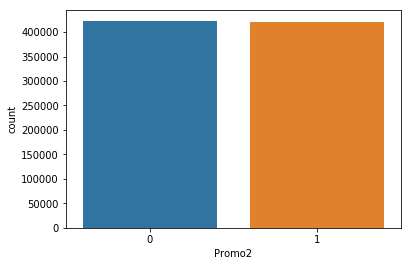

In [101]:
sns.countplot(df.Promo2)

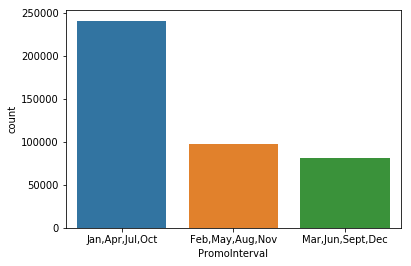

In [102]:
#promo interval is a categorical variable

sns.countplot(df.PromoInterval)

In [103]:
#change n/a values

In [104]:
df_sample.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,unique,holiday_a,holiday_b,holiday_c,year,month,promo_time,competition_time
269032,297,2,2015-03-17,8365,805,1,1,0,0,a,...,NaN,NaN,2972015-03-17,0,0,0,2015,3,0.0,54.0
975133,1069,5,2013-02-01,5625,714,1,0,0,0,a,...,2011.0,"Jan,Apr,Jul,Oct",10692013-02-01,0,0,0,2013,2,95.0,0.0
718088,789,2,2015-05-12,4152,589,1,0,0,0,a,...,NaN,NaN,7892015-05-12,0,0,0,2015,5,0.0,142.0
296911,327,6,2014-09-27,5793,742,1,0,0,0,c,...,NaN,NaN,3272014-09-27,0,0,0,2014,9,0.0,117.0
269227,297,3,2014-09-03,7176,726,1,1,0,1,a,...,NaN,NaN,2972014-09-03,0,0,0,2014,9,0.0,48.0


In [105]:
df_sample = df_sample.fillna(0)

Variables so far

- Store - categorical
- DayOfWeek - categorical
- Promo - dummy
- Promo2 - dummy
- StateHoliday - dummy (holiday_a, etc.)
- SchoolHoliday - dummy
- StoreType - categorical
- Assortment - categorical
- CompetitionDistance - continuous
- PromoInterval - categorical
- Promo_time - continuous
- Competition_time - continuous

Need to create dummy vars for DayOfWeek, StoreType, Assortment, PromoInterval, Store

In [106]:
df_sample = pd.get_dummies(
    df_sample,
    prefix = ['day','stype','assortment','interval','store'],
    columns = ['DayOfWeek','StoreType','Assortment','PromoInterval','Store']
                          )

In [107]:
df_sample = pd.get_dummies(
    df_sample,
    prefix = ['month'],
    columns = ['month']
                          )

In [108]:
#columns
for i in df_sample.columns[0:50]:
    print i

Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
unique
holiday_a
holiday_b
holiday_c
year
promo_time
competition_time
day_1
day_2
day_3
day_4
day_5
day_6
day_7
stype_a
stype_b
stype_c
stype_d
assortment_a
assortment_b
assortment_c
interval_0
interval_Feb,May,Aug,Nov
interval_Jan,Apr,Jul,Oct
interval_Mar,Jun,Sept,Dec
store_1
store_2
store_3
store_4
store_5
store_6
store_7
store_8
store_9
store_10
store_11
store_12


In [111]:
#month
df_sample.columns[-20:-1]

Index([u'store_1108', u'store_1109', u'store_1110', u'store_1111',
       u'store_1112', u'store_1113', u'store_1114', u'store_1115', u'month_1',
       u'month_2', u'month_3', u'month_4', u'month_5', u'month_6', u'month_7',
       u'month_8', u'month_9', u'month_10', u'month_11'],
      dtype='object')

In [129]:
df_sample.columns[-12:-1]

Index([u'month_1', u'month_2', u'month_3', u'month_4', u'month_5', u'month_6',
       u'month_7', u'month_8', u'month_9', u'month_10', u'month_11'],
      dtype='object')

https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

promo 2 conicides with "interval", so don't include both

In [130]:
column_list = df_sample.columns.tolist()

#column_list[10],

feature_list = [column_list[4], column_list[7]]
for i in column_list[14:17]:
    feature_list.append(i)
for i in column_list[18:28]:
    feature_list.append(i)
for i in column_list[31:32]:
    feature_list.append(i)
for i in column_list[35:37]:
    feature_list.append(i)
for i in column_list[38:1148]:
    feature_list.append(i)
for i in column_list[-12:-1]:
    feature_list.append(i)
    
feature_list[-1]

'month_11'

In [131]:
feature_list[0]

'Promo'

## make new variables for test set

In [132]:
test_df.shape

(41088, 8)

In [133]:
test_df = test_df[test_df['Open'] == 1]

In [134]:
test_df = pd.merge(test_df,store_df,left_on='Store',right_on='Store')

In [137]:
#to make this more reproducible, wrapping it in one function

def add_vars(dataframe):
    y = dataframe
    y['holiday_a'] = y.StateHoliday.apply(lambda x: holiday('a',x))
    y['holiday_b'] = y.StateHoliday.apply(lambda x: holiday('b',x))
    y['holiday_c'] = y.StateHoliday.apply(lambda x: holiday('c',x))
    y['unique'] = y['Store'].astype(str) + y['Date'].astype(str)
    y['promo_time'] = y.unique.apply(lambda x: promo_time(y,x))
    y['competition_time'] = y.unique.apply(lambda x: competition_time(y,x))
    y['month'] = y.unique.apply(lambda x: month_var(y,x))
    y = pd.get_dummies(
    y,
    prefix = ['day','stype','assortment','interval','store','month'],
    columns = ['DayOfWeek','StoreType','Assortment','PromoInterval','Store','month']
                          )
    y = y.fillna(0)
    return y

In [138]:
test_df = add_vars(test_df)

In [139]:
test_df.columns[0:50]

Index([u'Id', u'Date', u'Open', u'Promo', u'StateHoliday', u'SchoolHoliday',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'holiday_a', u'holiday_b', u'holiday_c', u'unique',
       u'promo_time', u'competition_time', u'day_1', u'day_2', u'day_3',
       u'day_4', u'day_5', u'day_6', u'day_7', u'stype_a', u'stype_b',
       u'stype_c', u'stype_d', u'assortment_a', u'assortment_b',
       u'assortment_c', u'interval_Feb,May,Aug,Nov',
       u'interval_Jan,Apr,Jul,Oct', u'interval_Mar,Jun,Sept,Dec', u'store_1',
       u'store_3', u'store_7', u'store_8', u'store_9', u'store_10',
       u'store_11', u'store_12', u'store_13', u'store_14', u'store_15',
       u'store_16', u'store_19', u'store_20', u'store_21'],
      dtype='object')

# Model 1 - Basic Ridge Regression - Predicting Sales

In [140]:
#set up the model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [141]:
y = df_sample['Sales']
x = df_sample[feature_list]

In [142]:
x.head()

,Promo,CompetitionDistance,holiday_a,holiday_b,holiday_c,promo_time,competition_time,day_1,day_2,day_3,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
269032,1,2300.0,0,0,0,0.0,54.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
975133,0,18050.0,0,0,0,95.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
718088,0,9770.0,0,0,0,0.0,142.0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
296911,0,1390.0,0,0,0,0.0,117.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
269227,1,2300.0,0,0,0,0.0,48.0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [143]:
#need to find the best alpha
clf = Ridge(alpha=1.0)
#just trying one for now

In [144]:
clf.fit(x,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

### Test outcome

In [145]:
#already have variable feature_list from before

In [146]:
df_validate = df.sample(frac=0.03)
df_validate.Store.nunique()

1113

In [147]:
df_validate = add_vars(df_validate)

In [148]:
df_validate = df_validate[df_validate.Sales != 0]

### Score

In [149]:
X = df_validate[feature_list]
df_validate['eval'] = clf.predict(X)

In [150]:
def evaluate(p,x):
    return np.mean(((x - p)/x) ** 2) ** .5

In [151]:
df_validate[['eval','Sales']].head()

,eval,Sales
596239,11150.886321,12799
996259,10269.403584,8980
95236,4897.409847,3507
862303,9949.348988,8850
310486,3901.047127,3927


In [152]:
evaluate(df_validate['eval'],df_validate['Sales'])

0.2602762616609264

# Model 2 - Ridge Regression With Grid Search - Predict Sales

In [153]:
# steps
steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

# Create the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=3)

In [154]:
y = df_sample['Sales']
x = df_sample[feature_list]

In [155]:
cv.fit(x,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-04,   1.20679e-04,   1.45635e-04,   1.75751e-04,
         2.12095e-04,   2.55955e-04,   3.08884e-04,   3.72759e-04,
         4.49843e-04,   5.42868e-04,   6.55129e-04,   7.90604e-04,
         9.54095e-04,   1.15140e-03,   1.38950e-03,   1.67683e-03,
    ...    3.90694e-01,   4.71487e-01,   5.68987e-01,   6.86649e-01,
         8.28643e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [156]:
X = df_validate[feature_list]
df_validate['eval_grid'] = cv.predict(X)

In [157]:
score2 = evaluate(df_validate['eval_grid'],df_validate['Sales'])
print score2

0.256988424102


# Model 3 - Ridge Regression With Instrumentation - Predict Customers, then Predict Sales

In [158]:
# steps
steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

# Create the GridSearchCV object: cv

#try k-folds = 10
cv1 = GridSearchCV(pipeline, parameters, cv=3)
cv2 = GridSearchCV(pipeline, parameters, cv=3)

In [159]:
y = df_sample['Customers']
x = df_sample[feature_list]

In [160]:
cv1.fit(x,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-04,   1.20679e-04,   1.45635e-04,   1.75751e-04,
         2.12095e-04,   2.55955e-04,   3.08884e-04,   3.72759e-04,
         4.49843e-04,   5.42868e-04,   6.55129e-04,   7.90604e-04,
         9.54095e-04,   1.15140e-03,   1.38950e-03,   1.67683e-03,
    ...    3.90694e-01,   4.71487e-01,   5.68987e-01,   6.86649e-01,
         8.28643e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [161]:
X = df_validate[feature_list]
df_validate['cust_inst'] = cv1.predict(X)

df_sample['cust_inst'] = cv1.predict(df_sample[feature_list])

In [162]:
evaluate(df_validate['cust_inst'],df_validate['Customers'])

0.22555480267883712

### Second part of the model using customer data

In [163]:
feature_list2 = feature_list + ['Customers']
feature_list3 = feature_list + ['cust_inst']

In [164]:
y = df_sample['Sales']
x = df_sample[feature_list3]

In [165]:
cv2.fit(x,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-04,   1.20679e-04,   1.45635e-04,   1.75751e-04,
         2.12095e-04,   2.55955e-04,   3.08884e-04,   3.72759e-04,
         4.49843e-04,   5.42868e-04,   6.55129e-04,   7.90604e-04,
         9.54095e-04,   1.15140e-03,   1.38950e-03,   1.67683e-03,
    ...    3.90694e-01,   4.71487e-01,   5.68987e-01,   6.86649e-01,
         8.28643e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [166]:
X = df_validate[feature_list3]
df_validate['eval_inst'] = cv2.predict(X)

In [167]:
score3 = evaluate(df_validate['eval_inst'],df_validate['Sales'])
print score3

0.256985546432


Not any better

# Model 4 - Use Scaling, Increase K-Folds

Ridge Regression uses built-in regularization but this does not comletely replace scaling. I'm going to try scaling sales and the number of customers.

In [168]:
# steps
steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

# Create the GridSearchCV object: cv

#try k-folds = 10
cv1 = GridSearchCV(pipeline, parameters, cv=3)
cv2 = GridSearchCV(pipeline, parameters, cv=3)

In [169]:
df_sample['log_customers'] = np.log(df_sample['Customers'])
df_validate['log_customers'] = np.log(df_validate['Customers'])

df_sample['log_sales'] = np.log(df_sample['Sales'])
df_validate['log_sales'] = np.log(df_validate['Sales'])

### Part 1 - Predict Log(Customers)

In [170]:
df_sample = df_sample[df_sample.Customers > 0] #this prevents infinity error

In [171]:
y = df_sample['log_customers']
x = df_sample[feature_list]

In [172]:
df_sample.shape

(25288, 1166)

In [173]:
cv1.fit(x,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-04,   1.20679e-04,   1.45635e-04,   1.75751e-04,
         2.12095e-04,   2.55955e-04,   3.08884e-04,   3.72759e-04,
         4.49843e-04,   5.42868e-04,   6.55129e-04,   7.90604e-04,
         9.54095e-04,   1.15140e-03,   1.38950e-03,   1.67683e-03,
    ...    3.90694e-01,   4.71487e-01,   5.68987e-01,   6.86649e-01,
         8.28643e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [174]:
X = df_validate[feature_list]
df_validate['log_customer_instrument'] = cv1.predict(X)

df_sample['log_customer_instrument'] = cv1.predict(df_sample[feature_list])

In [175]:
evaluate(df_validate['log_customer_instrument'],df_validate['log_customers'])

0.029352949618664477

In [176]:
evaluate(np.exp(df_validate['log_customer_instrument']),df_validate['Customers'])

0.2075081510450008

Better than before

### Part 2 - Predict Sales

In [177]:
y = df_sample['log_sales']
x = df_sample[feature_list + ['log_customers']]

In [178]:
cv2.fit(x,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([  1.00000e-04,   1.20679e-04,   1.45635e-04,   1.75751e-04,
         2.12095e-04,   2.55955e-04,   3.08884e-04,   3.72759e-04,
         4.49843e-04,   5.42868e-04,   6.55129e-04,   7.90604e-04,
         9.54095e-04,   1.15140e-03,   1.38950e-03,   1.67683e-03,
    ...    3.90694e-01,   4.71487e-01,   5.68987e-01,   6.86649e-01,
         8.28643e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [179]:
X = df_validate[feature_list + ['log_customers']]
df_validate['log_sales_predicted'] = cv2.predict(X)

In [180]:
score4 = evaluate(np.exp(df_validate['log_sales_predicted']),df_validate['Sales'])
print score4

0.067934640826


Rank: 1

Potential Next Steps
- Further optimization of alpha
- Increase in K-Folds
- Larger data sets (only using 2% of data is not ideal)
- Try other models

# Predict Final Values

In [181]:
test_df.head()

,Id,Date,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,store_1106,store_1107,store_1109,store_1111,store_1112,store_1113,store_1114,store_1115,month_8,month_9
0,1,2015-09-17,1.0,1,0,0,1270.0,9.0,2008.0,0,...,0,0,0,0,0,0,0,0,0,1
1,857,2015-09-16,1.0,1,0,0,1270.0,9.0,2008.0,0,...,0,0,0,0,0,0,0,0,0,1
2,1713,2015-09-15,1.0,1,0,0,1270.0,9.0,2008.0,0,...,0,0,0,0,0,0,0,0,0,1
3,2569,2015-09-14,1.0,1,0,0,1270.0,9.0,2008.0,0,...,0,0,0,0,0,0,0,0,0,1
4,4281,2015-09-12,1.0,0,0,0,1270.0,9.0,2008.0,0,...,0,0,0,0,0,0,0,0,0,1


In [182]:
test_df.shape

(35093, 893)

In [183]:
type(feature_list[0:10])

list

In [184]:
test_df.columns

Index([u'Id', u'Date', u'Open', u'Promo', u'StateHoliday', u'SchoolHoliday',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2',
       ...
       u'store_1106', u'store_1107', u'store_1109', u'store_1111',
       u'store_1112', u'store_1113', u'store_1114', u'store_1115', u'month_8',
       u'month_9'],
      dtype='object', length=893)

In [185]:
try:
    test_df['store_2']
except:
    print 'error'

error


In [187]:
#need to add missing columns
for i in feature_list:
    if i in test_df.columns.tolist():
        pass
    else:
        test_df[i] = 0

In [188]:
test_df['log_customers'] = cv1.predict(test_df[feature_list])
test_df['Sales'] = np.exp(cv2.predict(test_df[feature_list + ['log_customers']]))

In [189]:
submission=test_df[['Id','Sales']]

In [190]:
submission.head()

,Id,Sales
0,1,5065.437873
1,857,5027.109436
2,1713,5230.367783
3,2569,5958.109771
4,4281,3624.433916
